In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklearn utilities
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error as MSE 

# sklearn models
from sklearn import linear_model
from sklearn.svm import SVR

# Inputing Files

In [2]:
county_area = pd.read_csv('county_area.csv')
county_area = county_area.drop(["Areaname"], axis=1)
county_area = county_area.rename(columns={"STCOU": "fips"})
county_area

,fips,AREA
0,1001,604.49
1,1003,2027.08
2,1005,904.59
3,1007,625.50
4,1009,650.65
...,...,...
3123,56037,10491.73
3124,56039,4221.96
3125,56041,2087.66
3126,56043,2242.85


In [3]:
county_mask_use = pd.read_csv('mask_use.csv')
county_mask_use = county_mask_use.drop(["RARELY", "SOMETIMES", "FREQUENTLY"], axis=1)
county_mask_use = county_mask_use.rename(columns={"COUNTYFP": "fips"})
county_mask_use

,fips,NEVER,ALWAYS
0,1001,0.053,0.444
1,1003,0.083,0.436
2,1005,0.067,0.491
3,1007,0.020,0.572
4,1009,0.053,0.459
...,...,...,...
3123,56037,0.061,0.268
3124,56039,0.095,0.340
3125,56041,0.098,0.264
3126,56043,0.204,0.287


In [4]:
county_cases = pd.read_csv('county_cases.csv')
county_cases = county_cases.drop(["county","state"], axis=1)
county_cases

,fips,cases,deaths
0,1001,2059,31
1,1003,6658,69
2,1005,1033,9
3,1007,840,14
4,1009,1932,25
...,...,...,...
3123,56037,462,2
3124,56039,747,1
3125,56041,431,3
3126,56043,144,7


In [5]:
county_pop = pd.read_csv('county_pop.csv', encoding='latin-1')
county_pop = county_pop.rename(columns={"COUNTY": "fips"})
county_pop

,fips,STNAME,CTYNAME,POPESTIMATE2019
0,1001,Alabama,Autauga,55869
1,1003,Alabama,Baldwin,223234
2,1005,Alabama,Barbour,24686
3,1007,Alabama,Bibb,22394
4,1009,Alabama,Blount,57826
...,...,...,...,...
3123,56037,Wyoming,Sweetwater,42343
3124,56039,Wyoming,Teton,23464
3125,56041,Wyoming,Uinta,20226
3126,56043,Wyoming,Washakie,7805


## Merging Dataframes Together

In [6]:
df = county_pop.merge(county_cases, how='left', on="fips")
df = df.merge(county_mask_use, how='left', on="fips")
df = df.merge(county_area, how="left", on="fips")
df['POP_DEN'] = df['POPESTIMATE2019'] / df['AREA']
df['POP_DENxMASK'] = df['POP_DEN'] * df['ALWAYS']
df.insert(0, 'Ones', 1)
df

,Ones,fips,STNAME,CTYNAME,POPESTIMATE2019,cases,deaths,NEVER,ALWAYS,AREA,POP_DEN,POP_DENxMASK
0,1,1001,Alabama,Autauga,55869,2059,31,0.053,0.444,604.49,92.423365,41.035974
1,1,1003,Alabama,Baldwin,223234,6658,69,0.083,0.436,2027.08,110.125895,48.014890
2,1,1005,Alabama,Barbour,24686,1033,9,0.067,0.491,904.59,27.289711,13.399248
3,1,1007,Alabama,Bibb,22394,840,14,0.020,0.572,625.50,35.801759,20.478606
4,1,1009,Alabama,Blount,57826,1932,25,0.053,0.459,650.65,88.874203,40.793259
...,...,...,...,...,...,...,...,...,...,...,...,...
3123,1,56037,Wyoming,Sweetwater,42343,462,2,0.061,0.268,10491.73,4.035845,1.081607
3124,1,56039,Wyoming,Teton,23464,747,1,0.095,0.340,4221.96,5.557608,1.889587
3125,1,56041,Wyoming,Uinta,20226,431,3,0.098,0.264,2087.66,9.688359,2.557727
3126,1,56043,Wyoming,Washakie,7805,144,7,0.204,0.287,2242.85,3.479947,0.998745


## Normalize Data

In [7]:
def normalize(column):
    normal = []
    for value in column:
        value = (value - min(column)) / (max(column) - min(column))
        normal.append(value)
    return normal

In [8]:
normalize_pop = normalize(df['POPESTIMATE2019'])
normal_pop_df = pd.DataFrame(normalize_pop)
normal_pop_df

,0
0,0.005538
1,0.022210
2,0.002432
3,0.002204
4,0.005733
...,...
3123,0.004191
3124,0.002310
3125,0.001988
3126,0.000750


In [9]:
columns = ['POPESTIMATE2019','NEVER','ALWAYS','POP_DEN']
for col in columns:
    temp = normalize(df[col])
    if col == 'POPESTIMATE2019':
        normal_svm = pd.DataFrame(temp, columns=[col])
    else:
        normal_svm.insert(columns.index(col), col, temp)
normal_svm

,POPESTIMATE2019,NEVER,ALWAYS,POP_DEN
0,0.005538,0.122685,0.425065,0.008322
1,0.022210,0.192130,0.414729,0.009916
2,0.002432,0.155093,0.485788,0.002455
3,0.002204,0.046296,0.590439,0.003222
4,0.005733,0.122685,0.444444,0.008002
...,...,...,...,...
3123,0.004191,0.141204,0.197674,0.000361
3124,0.002310,0.219907,0.290698,0.000498
3125,0.001988,0.226852,0.192506,0.000870
3126,0.000750,0.472222,0.222222,0.000310


## Graphs

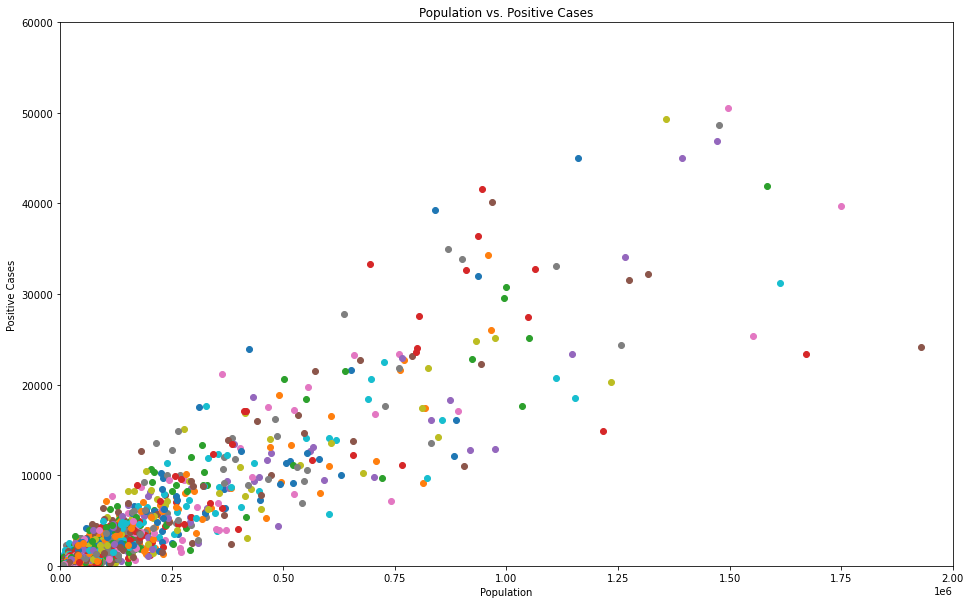

In [10]:
fig, ax = plt.subplots(figsize=(16,10))
for i in range(df.shape[0]):
    plt.scatter(df['POPESTIMATE2019'][i], df['cases'][i])
plt.xlabel('Population')
plt.ylabel('Positive Cases')
plt.ylim(0,60000)
plt.xlim(0,2000000)
plt.title('Population vs. Positive Cases')
plt.show()

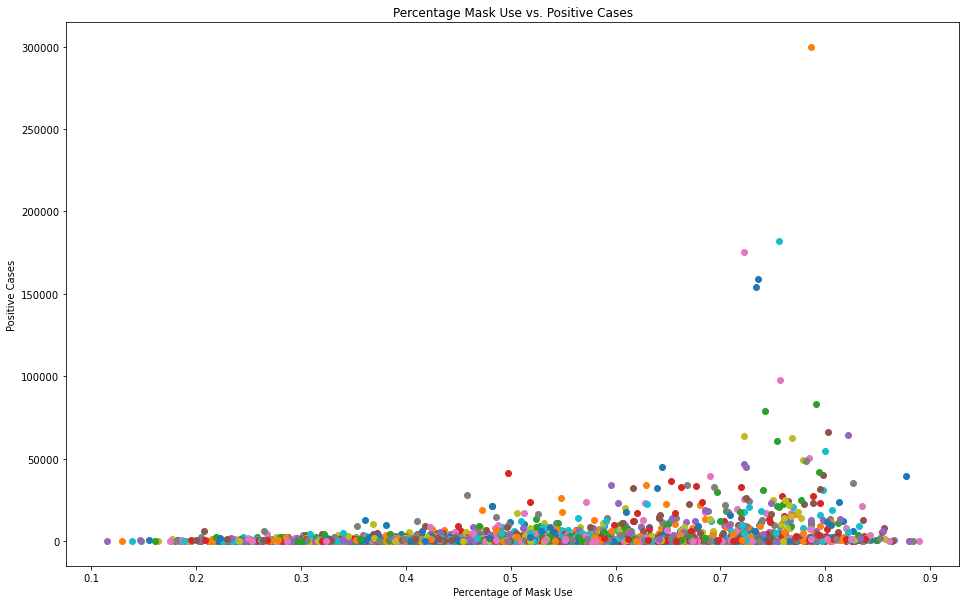

In [11]:
fig, ax = plt.subplots(figsize=(16,10))
for i in range(df.shape[0]):
    plt.scatter(df['ALWAYS'][i], df['cases'][i])
plt.xlabel('Percentage of Mask Use')
plt.ylabel('Positive Cases')
plt.title('Percentage Mask Use vs. Positive Cases')
plt.show()

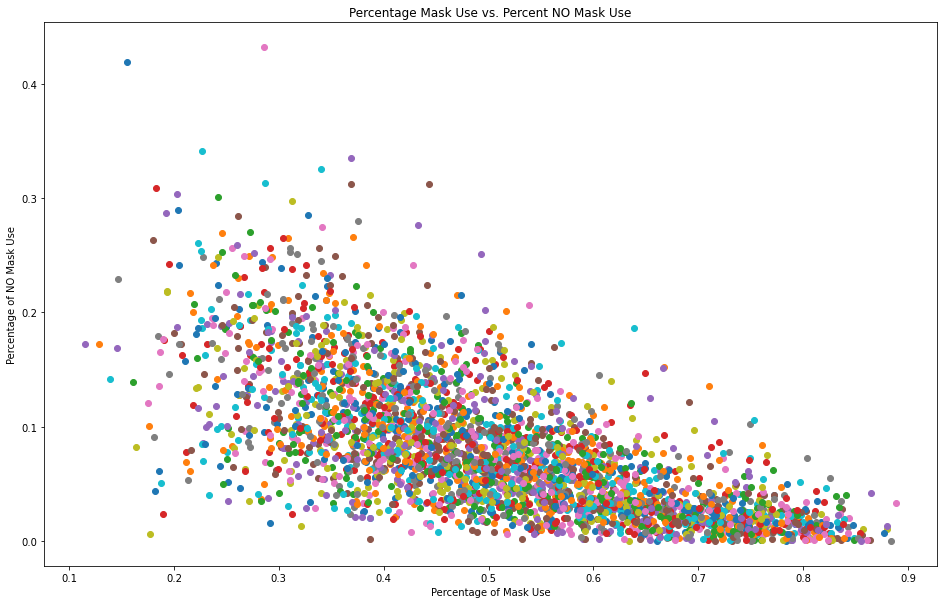

In [12]:
fig, ax = plt.subplots(figsize=(16,10))
for i in range(df.shape[0]):
    plt.scatter(df['ALWAYS'][i], df['NEVER'][i])
plt.xlabel('Percentage of Mask Use')
plt.ylabel('Percentage of NO Mask Use')
plt.title('Percentage Mask Use vs. Percent NO Mask Use')
plt.show()

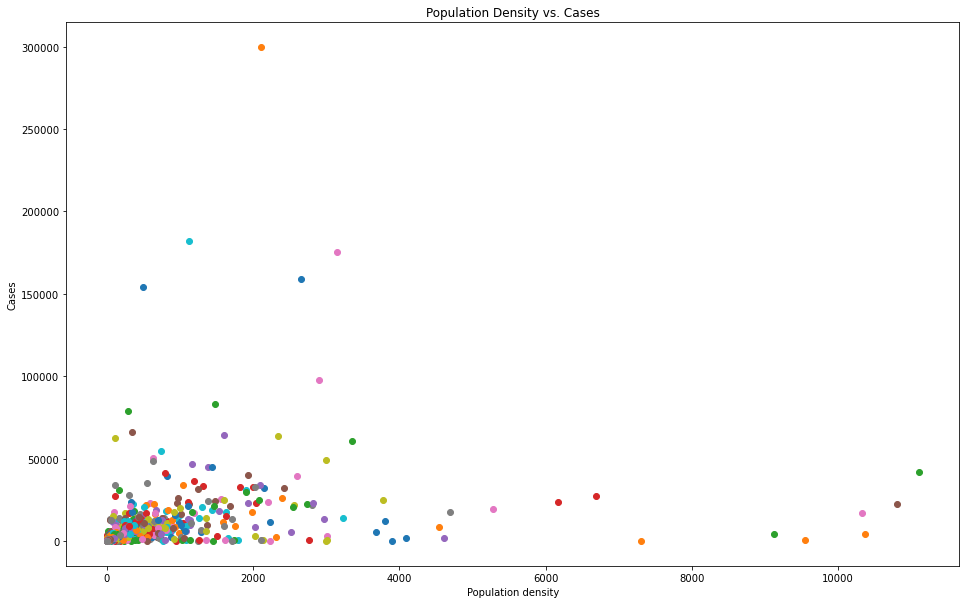

In [13]:
fig, ax = plt.subplots(figsize=(16,10))
for i in range(df.shape[0]):
    plt.scatter(df['POP_DEN'][i], df['cases'][i])
plt.xlabel('Population density')
plt.ylabel('Cases')
plt.title('Population Density vs. Cases')
plt.show()

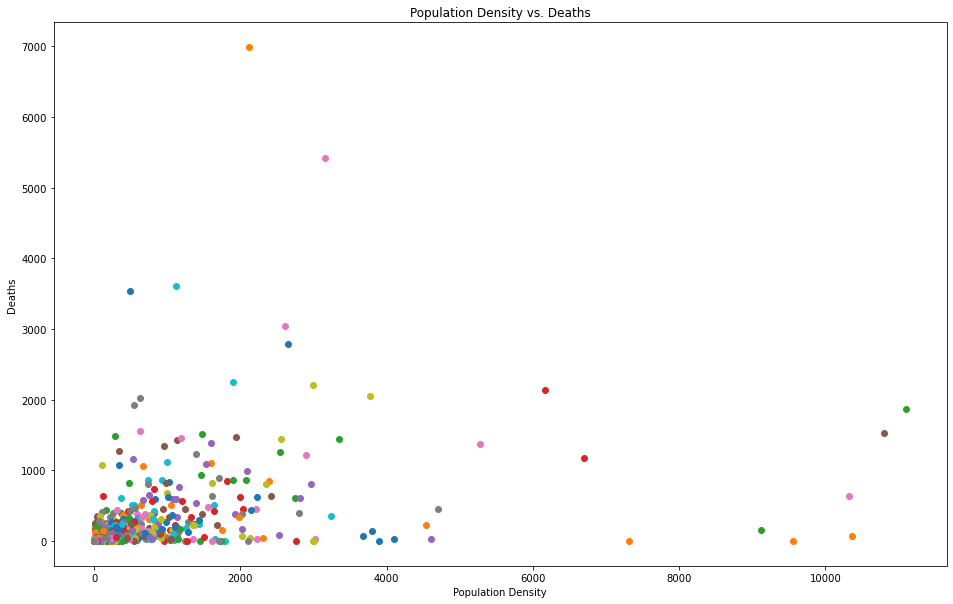

In [14]:
fig, ax = plt.subplots(figsize=(16,10))
for i in range(df.shape[0]):
    plt.scatter(df['POP_DEN'][i], df['deaths'][i])
plt.xlabel('Population Density')
plt.ylabel('Deaths')
plt.title('Population Density vs. Deaths')
plt.show()

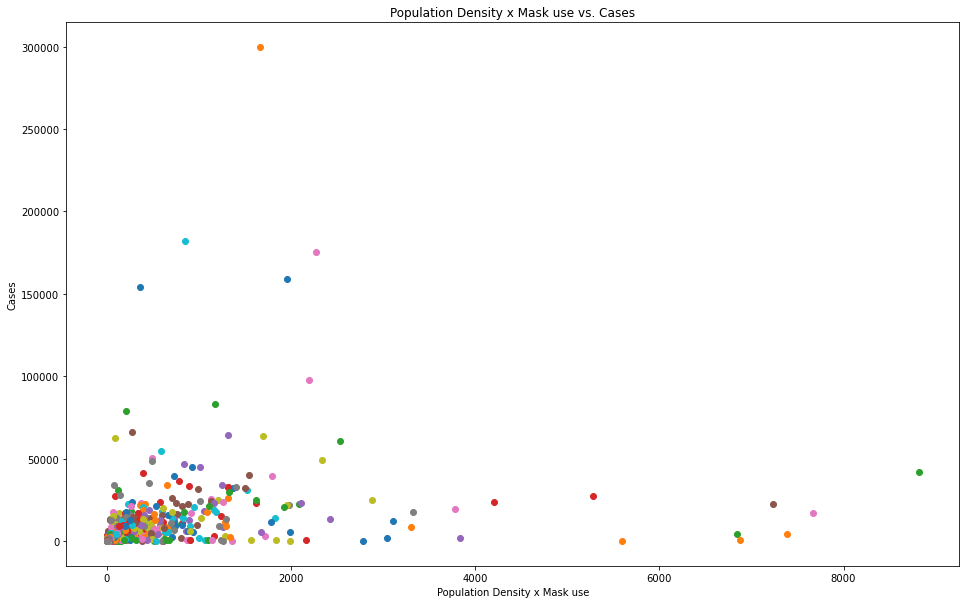

In [15]:
fig, ax = plt.subplots(figsize=(16,10))
for i in range(df.shape[0]):
    plt.scatter(df['POP_DENxMASK'][i], df['cases'][i])
plt.xlabel('Population Density x Mask use')
plt.ylabel('Cases')
plt.title('Population Density x Mask use vs. Cases')
plt.show()

## Split Data

In [56]:
def split(X, Y):
    return train_test_split(X, Y, test_size=0.2)

# Models

## Linear Regression

In [35]:
x_train, x_test, y_train, y_test = split(normal_pop_df, df['cases'])
x_train_lin = x_train.copy()
print(type(x_train_lin))
x_train_lin.insert(0, 'Ones', 1)
x = np.matrix(x_train_lin.values)
y = np.matrix(y_train.values)

<class 'pandas.core.frame.DataFrame'>


In [36]:
lin_regr = linear_model.LinearRegression(fit_intercept = False)
lin_regr.fit(x, y.T)
lin_regr.coef_ 

array([[  -346.62225242, 297490.54389066]])

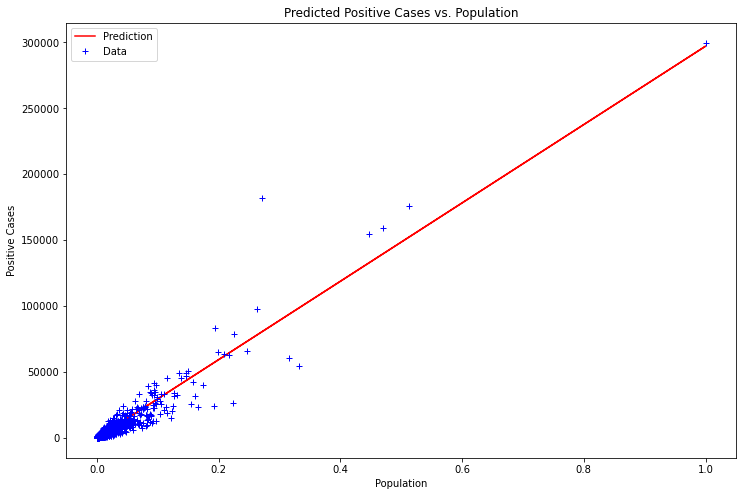

In [37]:
X = np.array(x[:, 1].A1)
f = lin_regr.predict(x).flatten()

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(X, f, color = "red", label='Prediction')
ax.plot(normal_pop_df[0], df['cases'], "r+",color = "blue", label='Data')
ax.legend(loc=2)
ax.set_xlabel('Population')
ax.set_ylabel('Positive Cases')
ax.set_title('Predicted Positive Cases vs. Population')
plt.show()

## SVM Regression

In [72]:
x_train, x_test, y_train, y_test = split(normal_svm, df['cases'])

In [74]:
normal_svm

,POPESTIMATE2019,NEVER,ALWAYS,POP_DEN
0,0.005538,0.122685,0.425065,0.008322
1,0.022210,0.192130,0.414729,0.009916
2,0.002432,0.155093,0.485788,0.002455
3,0.002204,0.046296,0.590439,0.003222
4,0.005733,0.122685,0.444444,0.008002
...,...,...,...,...
3123,0.004191,0.141204,0.197674,0.000361
3124,0.002310,0.219907,0.290698,0.000498
3125,0.001988,0.226852,0.192506,0.000870
3126,0.000750,0.472222,0.222222,0.000310


In [75]:
svr = SVR()
svr.fit(x_train, y_train)
svr_predict = svr.predict(x_test)

MSE(y_test, svr_predict)

58411748.11148451